In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.chdir("..")

from IPython.display import display

import sklearn.model_selection
import sklearn.metrics
import sklearn.datasets
from sklearn.ensemble import GradientBoostingClassifier

from Final_Data_Prep import remove_final_dummy, get_train_test, downsample

%matplotlib inline

import sys
sys.path.append("../")

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# read in fresh copy of df
df = pd.read_pickle('total_df.pckl.gz', compression = 'gzip')

In [5]:
'''
Data Prep (consistent with ADS as seen in Final_Gradient_Boosting_Model.ipynb)

Performing prep on total_df (here called df), not decoded_df as above in LIME
'''

#put earliest 85% of cases into training df, latest 15% of cases into test df
training, test = get_train_test(df, train_size=0.85, test_size=0.15)

# passing 50 to downsample function means training set will have 50% positive cases
training = downsample(training, 50)

X_train = training.drop('MHI', axis=1)
y_train = training['MHI']

X_test = test.drop('MHI', axis=1)
y_test = test['MHI']

In [6]:
clf_total = GradientBoostingClassifier(random_state=42, max_depth = 3, 
                                       min_samples_leaf = 10, learning_rate=.01, 
                                       n_estimators=1000)
clf_total.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [69]:
def get_stats(X_sub, col):
    ind = X_sub.index
    y_sub = y_test[ind]
    pred_sub = clf_total.predict(X_sub)
    pred_proba_sub = clf_total.predict_proba(X_sub)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_sub, pred_proba_sub[:,1])
    confmat_sub = sklearn.metrics.confusion_matrix(y_sub, pred_sub, labels=[1,0])
    tp = confmat_sub[0,0]
    fp = confmat_sub[1,0]
    fn = confmat_sub[0,1]
    tn = confmat_sub[1,1]
    stats = pd.DataFrame(data={col:[len(pred_sub), 
                                    round(sum(pred_sub)/len(pred_sub), 4),
                                    round((tp+tn)/len(pred_sub), 4),
                                    round(fn/(fn+tp), 4),
                                    round(fp/(fp+tn), 4),
                                    round(tp/(tp+fn), 4),
                                    round(sklearn.metrics.auc(fpr, tpr), 4)]}, 
                 index=['Test Set Group Size (N)', 'Predicted Prevalence', 
                        'Accuracy', 'FNR', 'FPR', 'Recall', 'AUC'])
    
    stats = stats.T
    stats['Test Set Group Size (N)'] = stats['Test Set Group Size (N)'].astype(int)
    display(stats)
    sklearn.metrics.plot_confusion_matrix(clf_total, X_sub, y_sub, labels=[1,0])
    plt.show()
    print('\n')
    return stats
    
    
def subgroup_stats(category1, category2=None):
    '''
    Takes in 1 or 2 pre-OHE column names (e.g., 'race' and 'gender').
    If 2 categories given, produces intersectional statistics.
    '''
    cols_1 = [x for x in X_test.columns if x.startswith(category1+'_')]
    total_stats = get_stats(X_test, 'Overall')
    if category2 !=None:
        cols_2 = [x for x in X_test.columns if x.startswith(category2+'_')]
        for y in cols_2:
            X_sub = X_test[X_test[y]==1]
            if len(X_sub)==0:
                print(y,'\n\t No members of this subgroup present in the test set. \n')
            else:
                sub_stats = get_stats(X_sub, y+', all '+category1+'s')
                total_stats = pd.concat([total_stats, sub_stats])
        for x in cols_1:
            X_sub = X_test[X_test[x]==1]
            if len(X_sub)==0:
                print(x,'\n\t No members of this subgroup present in the test set. \n')
                continue
            else:
                sub_stats = get_stats(X_sub, x+', all '+category2+'s')
                total_stats = pd.concat([total_stats, sub_stats])
                for y in cols_2:
                    X_sub = X_test[X_test[x]==1]
                    X_sub = X_sub[X_sub[y]==1]
                    if len(X_sub)==0:
                        print(x+' and '+y,'\n\t No members of this subgroup present in the test set. \n')
                    else:
                        sub_stats = get_stats(X_sub, x+' and '+y)
                        total_stats = pd.concat([total_stats, sub_stats])
    else:
        for x in cols_1:
            X_sub = X_test[X_test[x]==1]
            if len(X_sub)==0:
                print(x,'\n\t No members of this subgroup present in the test set. \n')
            else:
                sub_stats = get_stats(X_sub, x)
                total_stats = pd.concat([total_stats, sub_stats])
    display(total_stats)
    print('\n')
    return

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
Overall,43363,0.2384,0.7651,0.2077,0.235,0.7923,0.8411


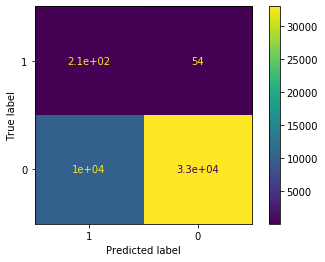

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
gender_female,5582,0.6141,0.3968,0.0704,0.6101,0.9296,0.8228


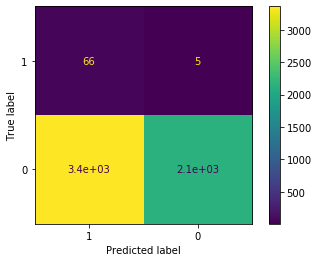

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
gender_male,37546,0.1831,0.8194,0.2593,0.1802,0.7407,0.8395


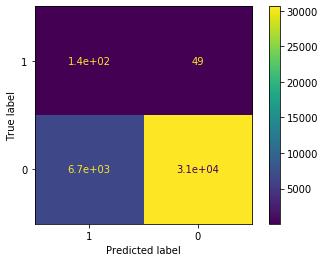

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
gender_unknown,235,0.1532,0.8468,NaN,0.1532,NaN,NaN


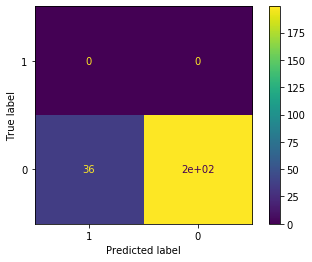

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
Overall,43363,0.2384,0.7651,0.2077,0.2350,0.7923,0.8411
gender_female,5582,0.6141,0.3968,0.0704,0.6101,0.9296,0.8228
gender_male,37546,0.1831,0.8194,0.2593,0.1802,0.7407,0.8395
gender_unknown,235,0.1532,0.8468,NaN,0.1532,NaN,NaN


In [70]:
subgroup_stats('gender')

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
Overall,43363,0.2384,0.7651,0.2077,0.235,0.7923,0.8411


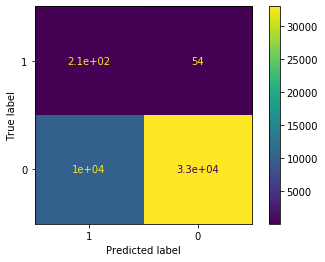



race_albino 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_american indian,7,0.7143,0.2857,NaN,0.7143,NaN,NaN


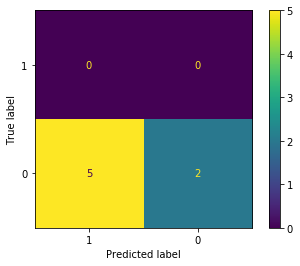

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_asian,224,0.3214,0.692,0.0,0.3122,1.0,0.8612


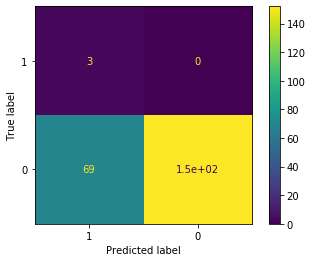

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_biracial,5,0.2,0.8,NaN,0.2,NaN,NaN


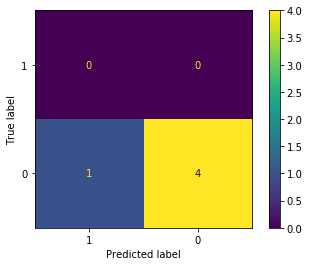

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_black,29269,0.2143,0.7889,0.2262,0.2111,0.7738,0.8407


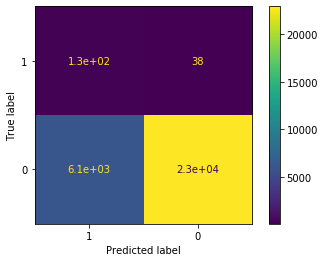

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_hispanic,446,0.1076,0.8946,0.0,0.1056,1.0,0.9933


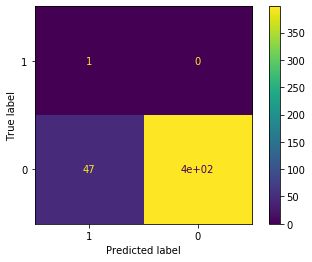

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_unknown,420,0.181,0.819,NaN,0.181,NaN,NaN


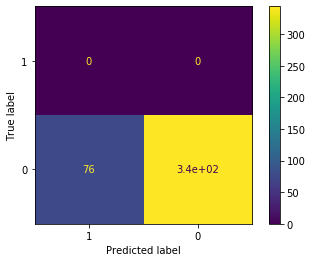

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white,6000,0.407,0.6005,0.1053,0.4023,0.8947,0.8423


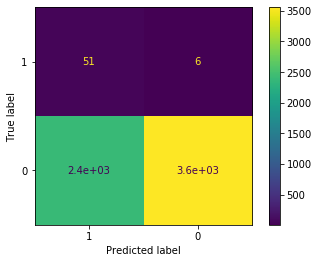

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white [hispanic or latino],6751,0.2023,0.799,0.3448,0.2004,0.6552,0.7919


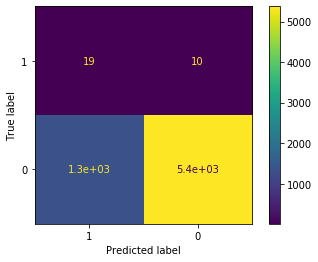

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white/black [hispanic or latino],241,0.2282,0.7801,0.0,0.2218,1.0,1.0


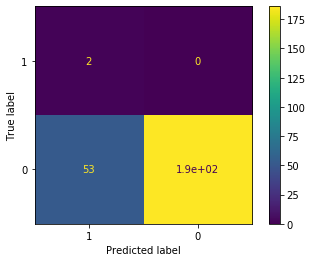

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
Overall,43363,0.2384,0.7651,0.2077,0.2350,0.7923,0.8411
race_american indian,7,0.7143,0.2857,NaN,0.7143,NaN,NaN
race_asian,224,0.3214,0.6920,0.0000,0.3122,1.0000,0.8612
race_biracial,5,0.2000,0.8000,NaN,0.2000,NaN,NaN
race_black,29269,0.2143,0.7889,0.2262,0.2111,0.7738,0.8407
race_hispanic,446,0.1076,0.8946,0.0000,0.1056,1.0000,0.9933
race_unknown,420,0.1810,0.8190,NaN,0.1810,NaN,NaN
race_white,6000,0.4070,0.6005,0.1053,0.4023,0.8947,0.8423
race_white [hispanic or latino],6751,0.2023,0.7990,0.3448,0.2004,0.6552,0.7919
race_white/black [hispanic or latino],241,0.2282,0.7801,0.0000,0.2218,1.0000,1.0000


In [71]:
subgroup_stats('race')

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
Overall,43363,0.2384,0.7651,0.2077,0.235,0.7923,0.8411


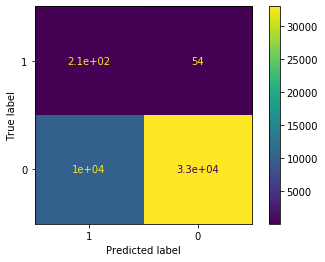

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
"gender_female, all races",5582,0.6141,0.3968,0.0704,0.6101,0.9296,0.8228


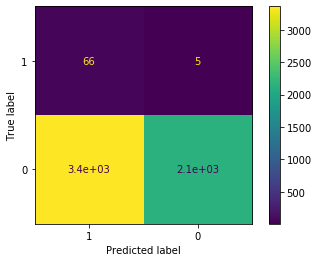

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
"gender_male, all races",37546,0.1831,0.8194,0.2593,0.1802,0.7407,0.8395


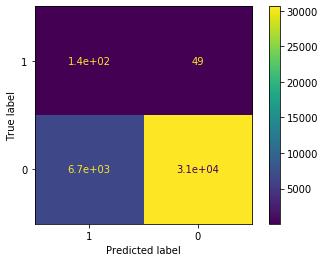

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
"gender_unknown, all races",235,0.1532,0.8468,NaN,0.1532,NaN,NaN


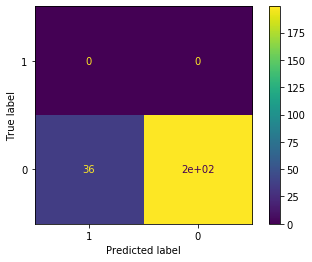



race_albino 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
"race_american indian, all genders",7,0.7143,0.2857,NaN,0.7143,NaN,NaN


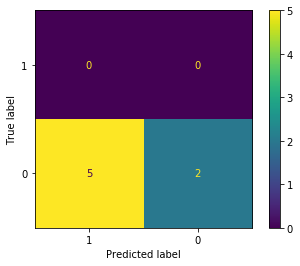

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_american indian and gender_female,3,1.0,0.0,NaN,1.0,NaN,NaN


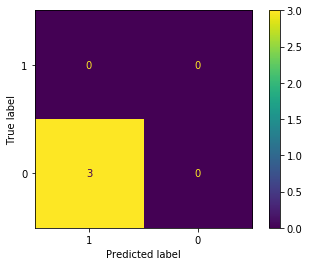

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_american indian and gender_male,4,0.5,0.5,NaN,0.5,NaN,NaN


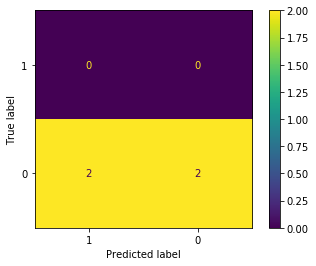



race_american indian and gender_unknown 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
"race_asian, all genders",224,0.3214,0.692,0.0,0.3122,1.0,0.8612


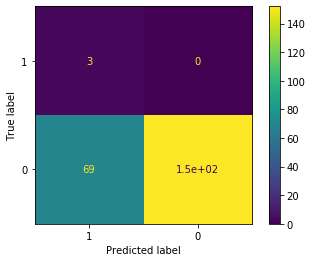

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_asian and gender_female,39,0.6923,0.3333,0.0,0.6842,1.0,0.9474


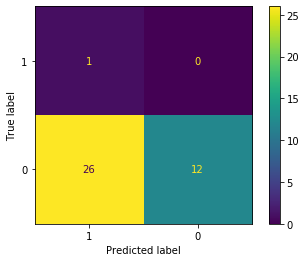

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_asian and gender_male,185,0.2432,0.7676,0.0,0.235,1.0,0.8634


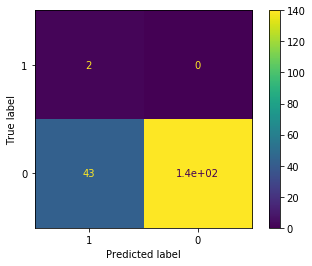



race_asian and gender_unknown 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
"race_biracial, all genders",5,0.2,0.8,NaN,0.2,NaN,NaN


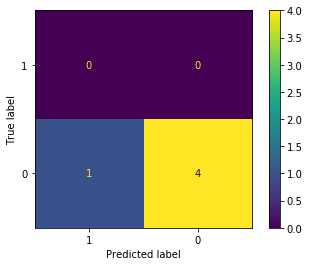



race_biracial and gender_female 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_biracial and gender_male,5,0.2,0.8,NaN,0.2,NaN,NaN


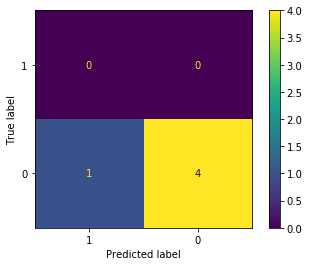



race_biracial and gender_unknown 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
"race_black, all genders",29269,0.2143,0.7889,0.2262,0.2111,0.7738,0.8407


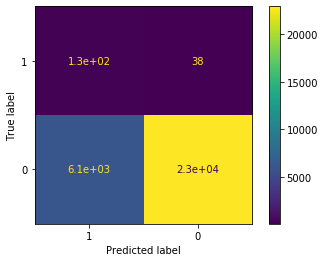

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_black and gender_female,3424,0.6133,0.3992,0.0426,0.6085,0.9574,0.8187


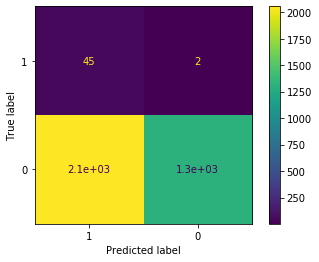

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_black and gender_male,25824,0.1616,0.8403,0.2975,0.159,0.7025,0.8359


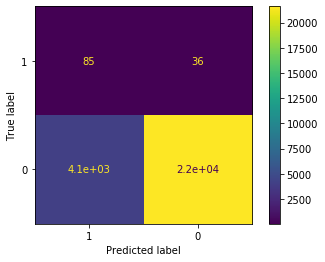

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_black and gender_unknown,21,0.0,1.0,NaN,0.0,NaN,NaN


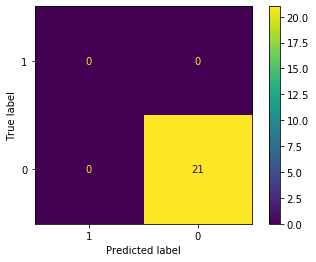

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
"race_hispanic, all genders",446,0.1076,0.8946,0.0,0.1056,1.0,0.9933


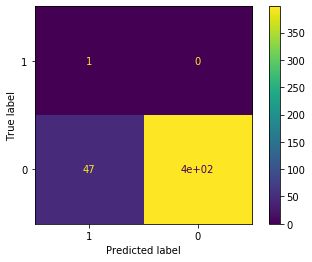

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_hispanic and gender_female,45,0.4889,0.5333,0.0,0.4773,1.0,0.9318


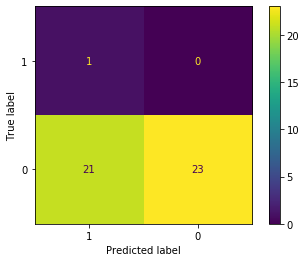

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_hispanic and gender_male,401,0.0648,0.9352,NaN,0.0648,NaN,NaN


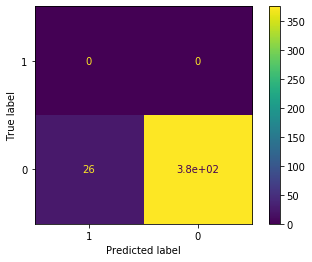



race_hispanic and gender_unknown 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
"race_unknown, all genders",420,0.181,0.819,NaN,0.181,NaN,NaN


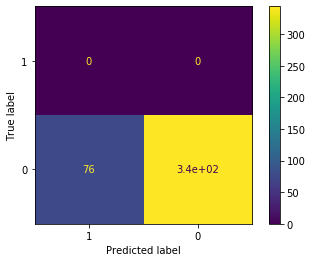

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_unknown and gender_female,34,0.5294,0.4706,NaN,0.5294,NaN,NaN


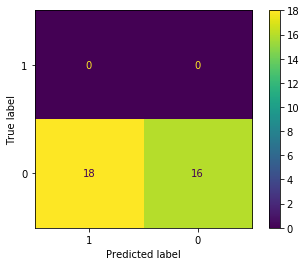

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_unknown and gender_male,178,0.1236,0.8764,NaN,0.1236,NaN,NaN


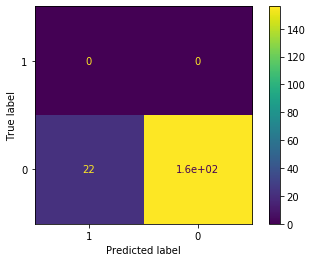

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_unknown and gender_unknown,208,0.1731,0.8269,NaN,0.1731,NaN,NaN


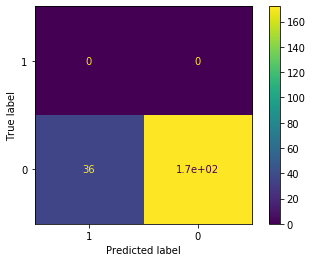

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
"race_white, all genders",6000,0.407,0.6005,0.1053,0.4023,0.8947,0.8423


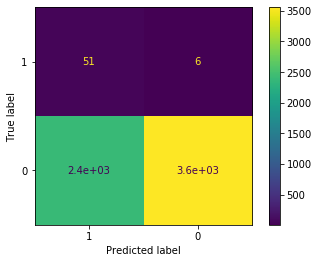

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white and gender_female,1345,0.6431,0.3651,0.0769,0.6404,0.9231,0.8544


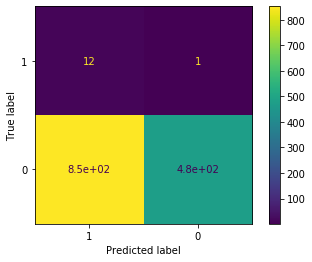

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white and gender_male,4653,0.3389,0.6684,0.1136,0.3337,0.8864,0.855


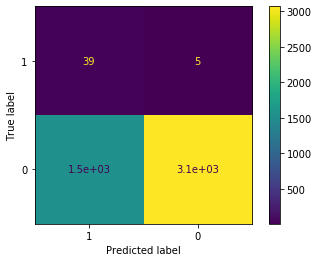

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white and gender_unknown,2,0.0,1.0,NaN,0.0,NaN,NaN


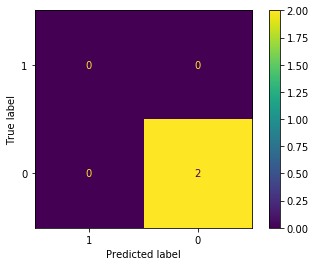

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
"race_white [hispanic or latino], all genders",6751,0.2023,0.799,0.3448,0.2004,0.6552,0.7919


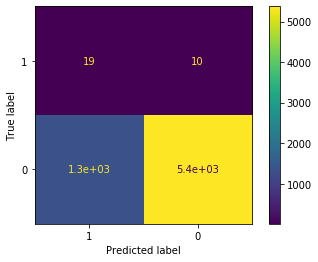

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white [hispanic or latino] and gender_female,664,0.5633,0.4413,0.2857,0.5616,0.7143,0.7364


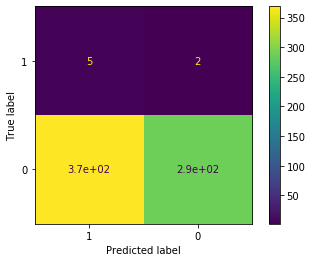

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white [hispanic or latino] and gender_male,6083,0.1631,0.8379,0.3636,0.1614,0.6364,0.7814


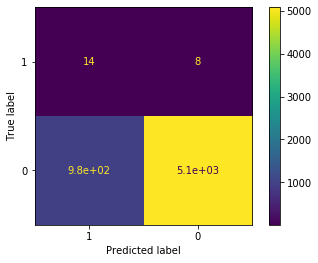

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white [hispanic or latino] and gender_unknown,4,0.0,1.0,NaN,0.0,NaN,NaN


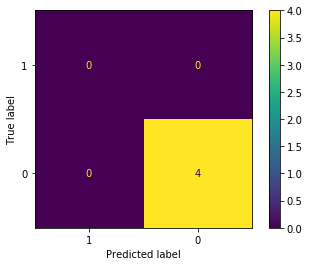

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
"race_white/black [hispanic or latino], all genders",241,0.2282,0.7801,0.0,0.2218,1.0,1.0


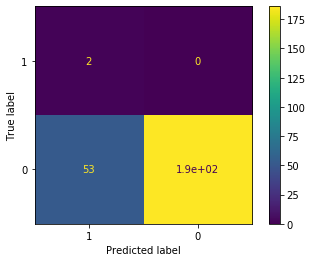

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white/black [hispanic or latino] and gender_female,28,0.6786,0.3929,0.0,0.6538,1.0,1.0


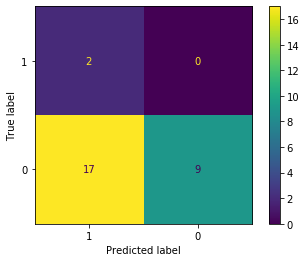

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white/black [hispanic or latino] and gender_male,213,0.169,0.831,NaN,0.169,NaN,NaN


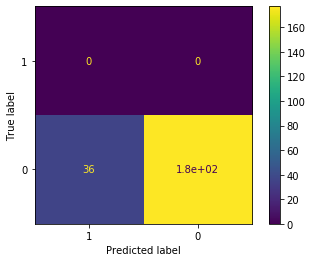



race_white/black [hispanic or latino] and gender_unknown 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
Overall,43363,0.2384,0.7651,0.2077,0.2350,0.7923,0.8411
"gender_female, all races",5582,0.6141,0.3968,0.0704,0.6101,0.9296,0.8228
"gender_male, all races",37546,0.1831,0.8194,0.2593,0.1802,0.7407,0.8395
"gender_unknown, all races",235,0.1532,0.8468,NaN,0.1532,NaN,NaN
"race_american indian, all genders",7,0.7143,0.2857,NaN,0.7143,NaN,NaN
race_american indian and gender_female,3,1.0000,0.0000,NaN,1.0000,NaN,NaN
race_american indian and gender_male,4,0.5000,0.5000,NaN,0.5000,NaN,NaN
"race_asian, all genders",224,0.3214,0.6920,0.0000,0.3122,1.0000,0.8612
race_asian and gender_female,39,0.6923,0.3333,0.0000,0.6842,1.0000,0.9474
race_asian and gender_male,185,0.2432,0.7676,0.0000,0.2350,1.0000,0.8634


In [72]:
subgroup_stats('race', 'gender')